In [22]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import date_format
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql.functions import unix_timestamp, from_unixtime
#import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import shutil
#init_notebook_mode(connected=True)
spark = SparkSession.builder.appName("Python Spark SQL basic example").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
df = sqlContext.read.load('/test_dev/mba-code/dataset.csv', format='csv', header='true', inferSchema='true')
df.select("InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate","InvoiceDateWS" ,date_format(from_unixtime(unix_timestamp('InvoiceDateWS', 'mm/dd/yyy')), 'EEEE').alias('weekday'),"CustomerID","Country").write.save("Invoices.parquet", format="parquet")
parquetFile = spark.read.parquet("Invoices.parquet")
# Parquet files can also be used to create a temporary view and then used in SQL statements.
parquetFile.createOrReplaceTempView("parquetFile")

In [28]:
import pyspark.sql.functions as f
DescriptionGrp = spark.sql("SELECT distinct Description,Count(Quantity) as QCount FROM parquetFile group by Description order by QCount desc")
#DescriptionGrp.coalesce(1).write.format("csv").option("header", "true").save("DescriptionGrp")
DescriptionGrp.coalesce(1).groupby('Description').agg(f.count('Description').alias('Count')).show()
#pandas_df = DescriptionGrp.coalesce(1).groupby('Description').agg(f.count('Description').alias('Count')).toPandas()
#DescriptionGrp.coalesce(1).groupby('Description').agg(f.count('Description').alias('DescCount')).show()
#print(pandas_df)

+--------------------+-----+
|         Description|Count|
+--------------------+-----+
|WHITE HANGING HEA...|    1|
|REGENCY CAKESTAND...|    1|
|JUMBO BAG RED RET...|    1|
|       PARTY BUNTING|    1|
|LUNCH BAG RED RET...|    1|
|ASSORTED COLOUR B...|    1|
|SET OF 3 CAKE TIN...|    1|
|PACK OF 72 RETROS...|    1|
|LUNCH BAG  BLACK ...|    1|
|NATURAL SLATE HEA...|    1|
|             POSTAGE|    1|
|JUMBO BAG PINK PO...|    1|
|HEART OF WICKER S...|    1|
|JAM MAKING SET WI...|    1|
|JUMBO STORAGE BAG...|    1|
|PAPER CHAIN KIT 5...|    1|
|JUMBO SHOPPER VIN...|    1|
| LUNCH BAG CARS BLUE|    1|
|LUNCH BAG SPACEBO...|    1|
|JAM MAKING SET PR...|    1|
+--------------------+-----+
only showing top 20 rows



In [26]:
from IPython.display import HTML, display
MostObjsPerDay = spark.sql("SELECT Description,InvoiceDateWS as PURCHASEDATE FROM parquetFile group by Description,PURCHASEDATE order by Description")
MostObjsPerDay.coalesce(1).groupby('PURCHASEDATE').agg(f.count('PURCHASEDATE').alias('Count')).write.format("csv").option("header", "true").save("MostObjsPerDay")

In [25]:
TopPerCust = spark.sql("SELECT distinct Description,Count(Quantity) as QCount,CustomerID FROM parquetFile group by Description,CustomerID order by QCount")
TopPerCust.coalesce(1).groupby('CustomerID').agg(f.count('CustomerID').alias('Count')).write.format("csv").option("header", "true").save("TopPerCust")

AnalysisException: u'path file:/test_dev/mba-code/TopPerCust already exists.;'

     weekday   count
0  Wednesday   57627
1       None  493992
2     Friday   72648
3   Saturday   77930
4   Thursday   69742
5     Sunday   75181
6    Tuesday   71129
7     Monday   69735


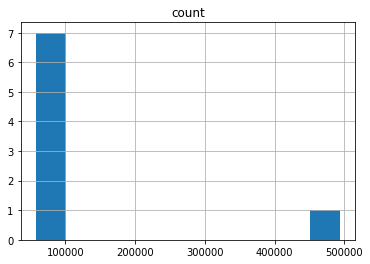

In [31]:
WeekdayPerProduct = spark.sql("SELECT distinct Description,InvoiceDateWS,weekday ,Count(Quantity) as QCount,CustomerID FROM parquetFile group by Description,CustomerID,weekday,InvoiceDateWS order by QCount")
pandas_df = WeekdayPerProduct.cube("weekday").count().toPandas()
print(pandas_df)
ax = pandas_df.hist()